#### Importing required libraries

In [150]:
import json
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torchtext.vocab import GloVe

In [151]:
with open('NER_TRAIN_JUDGEMENT.json') as file:
    data = json.load(file)

In [152]:
with open('NER_TEST_JUDGEMENT.json') as file:
    test_data = json.load(file)

In [153]:
train, val = train_test_split(data, test_size=0.15, random_state=42)

#### BIO Encoding of data

In [154]:
unique_labels = set()
for i in range(len(data)):
    for annotation in data[i]['annotations'][0]['result']:
        label = annotation['value']['labels'][0]
        unique_labels.add(label)
print(unique_labels)
print(len(unique_labels))

{'OTHER_PERSON', 'JUDGE', 'RESPONDENT', 'PRECEDENT', 'DATE', 'PROVISION', 'STATUTE', 'WITNESS', 'PETITIONER', 'GPE', 'CASE_NUMBER', 'ORG', 'COURT'}
13


#### Cleaning Data - Replacing escape sequences with spaces

In [155]:
def clean_text(text):
    special_chars = ['\x05', '\t', '\n', '\x0c', '\x11', '\x12', '\x13', '\x14', '\x16', '\x1a', '\x80', '\x9d', '\xa0', '\xad', '\uf076']
    for char in special_chars:
        text = text.replace(char, ' ')
    return text

#### Storing all the label boundaries in a list

In [156]:
def border_index(annotations):
    border_indices = []
    for annotation in annotations[0]['result']:
        start = annotation['value']['start']
        end = annotation['value']['end']
        label = annotation['value']['labels'][0]
        label = label.upper()
        border_indices.append([start, end, label])
    border_indices.sort(key=lambda x: x[0])
    return border_indices

#### Adding spaces on the boundaries of labels where there is no space

In [157]:
def border_spacing(text, border_indices):
    i = 0
    while i < len(text):
        for border in border_indices:
            if (i==border[0] or i==border[1]):
                index = border_indices.index(border)
                if (i==border[0] and i!=0 and text[i-1]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                if (i==border[1] and i!=len(text)-1 and text[i]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                i += 1
        i += 1
    return text, border_indices

#### Performing Tokenization by space and BIO Encoding

In [158]:
def bio_encoding(text, border_indices):
    tokens = text.split()
    labels = ['O'] * len(tokens)
    for annotation in border_indices:
        start = annotation[0]
        end = annotation[1]
        label = annotation[2]
        label = label.upper()
        label_start_token = None
        label_end_token = None
        curr_token_index = 0
        i = 0
        while (i < len(text)):
            if (text[i] == ' '):
                i += 1
            else:
                curr_word = ''
                if (i == start):
                    label_start_token = curr_token_index
                    while (i < end):
                        current_word = ''
                        if (text[i] == ' '):
                            while (text[i] == ' '):
                                i += 1
                        else: 
                            while (i < len(text) and text[i] != ' '):
                                current_word += text[i]
                                i += 1
                            if (tokens[curr_token_index] == current_word):
                                curr_token_index += 1
                    label_end_token = curr_token_index
                else: 
                    while (i < len(text) and text[i] != ' '):
                        curr_word += text[i]
                        i += 1
                    if (tokens[curr_token_index] == curr_word):
                        curr_token_index += 1
        if (label_end_token == None):
            label_end_token = len(tokens) - 1
        if (label_start_token == None):
            continue
        for i in range(label_start_token, label_end_token):
            if i == label_start_token:
                labels[i] = 'B_' + label
            else:
                labels[i] = 'I_' + label
    return labels

#### BIO Encoding of data

In [159]:
def convert_to_bio(data):
    processed_data = {}
    for i in range(len(data)):
        id = data[i]['id']
        annotations = data[i]['annotations']
        text = data[i]['data']['text']
        text = clean_text(text)
        border_indices = border_index(annotations)
        text, border_indices = border_spacing(text, border_indices)
        labels = bio_encoding(text, border_indices)
        processed_data[id] = {'text': text, 'labels': labels}
    return processed_data

#### Saving the data

In [160]:
processed_train = convert_to_bio(train)
processed_val = convert_to_bio(val)
processed_test = convert_to_bio(test_data)

In [161]:
# dumping the processed data
with open('NER_TRAIN_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_train, file, indent=4)
with open('NER_VAL_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_val, file, indent=4)
with open('NER_TEST_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_test, file, indent=4)

#### Preparing the data


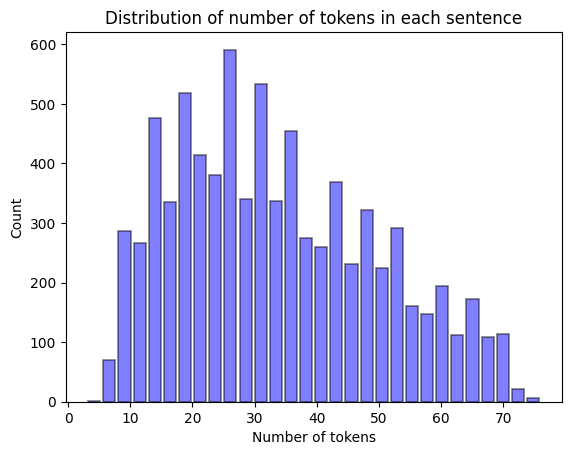

In [162]:
# plotting data distribution of number of tokens in each sentence
import matplotlib.pyplot as plt
label_counts = []
for key in processed_train.keys():
    label_counts.append(len(processed_train[key]['labels']))
plt.hist(label_counts, bins=30, alpha=0.5, color='b', edgecolor='black', linewidth=1.2, histtype='bar', align='mid', orientation='vertical', rwidth=0.8, label='Number of tokens')
plt.title('Distribution of number of tokens in each sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [163]:
train, val, test = [], [], []
for i in processed_train:
    train.append([processed_train[i]['text'], processed_train[i]['labels']])
for i in processed_val:
    val.append([processed_val[i]['text'], processed_val[i]['labels']])
for i in processed_test:
    test.append([processed_test[i]['text'], processed_test[i]['labels']])

In [164]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019
Validation data size: 1416
Test data size: 949


In [165]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: Therefore, while interpreting statutory provisions, the courts should keep in mind the objectives or purpose for which statute has been enacted.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The petitioner in W.P.No.15821 of 2008 was never considered for appointment under the National Rural Employment Guarantee Scheme either through Employment Exchange sponsorship or by Outsourcing Agencies.
Labels: ['O', 'O', 'O', 'B_CASE_NUMBER', 'I_CASE_NUMBER', 'I_CASE_NUMBER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The factum of accident, allegation of rash and negligent driving causing death of Sukendra Pal Singh were denied.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_OTHER_PERSON', 'I_OTHER_PERSON', 'I_OTHER_PERSON', 'O', 'O']

Text: ..36..    W.A.No.655/2012 & others Meaning thereby that ex

In [166]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [167]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [168]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {"O": 0}
idx = 1
for i in unique_labels:
    label_to_idx["B_" + i] = idx
    label_to_idx["I_" + i] = idx + 1
    idx += 2
print(label_to_idx)
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

{'O': 0, 'B_OTHER_PERSON': 1, 'I_OTHER_PERSON': 2, 'B_JUDGE': 3, 'I_JUDGE': 4, 'B_RESPONDENT': 5, 'I_RESPONDENT': 6, 'B_PRECEDENT': 7, 'I_PRECEDENT': 8, 'B_DATE': 9, 'I_DATE': 10, 'B_PROVISION': 11, 'I_PROVISION': 12, 'B_STATUTE': 13, 'I_STATUTE': 14, 'B_WITNESS': 15, 'I_WITNESS': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'B_GPE': 19, 'I_GPE': 20, 'B_CASE_NUMBER': 21, 'I_CASE_NUMBER': 22, 'B_ORG': 23, 'I_ORG': 24, 'B_COURT': 25, 'I_COURT': 26}
Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]


In [169]:
glove_vectors = GloVe(name='6B', dim=300)
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = glove_vectors[word]
    else:
        word_embeddings[idx] = glove_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (37868, 300)


In [170]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


#### Setting up DataLoaders

In [171]:
def collate_fn(batch):
    """
        Padding the sequences to the maximum length sequence in the batch
        Args:
            batch: list of individual elements of the dataset
        Returns:
            {'text' : padded_texts, 'labels' : padded_labels}
    """
    texts, labels = [item['text'] for item in batch], [item['labels'] for item in batch]
    max_len = max([len(text) for text in texts])
    padded_texts, padded_labels = [], []
    for i in range(len(texts)):
        text, label = texts[i], labels[i]
        # padding text and label sequences
        text = text + [word_to_index['PAD']] * (max_len - len(text))
        label = label + [label_to_idx['O']] * (max_len - len(label))
        padded_texts.append(text)
        padded_labels.append(label)
    return {'text': torch.tensor(padded_texts), 'labels': torch.tensor(padded_labels)}

In [172]:
class LegalDataset(Dataset):
    """
        Custom Dataset to load the Laptop Review dataset
        Args:
            data: list of tuples (text, labels)
            vocab_size: size of the vocabulary
            embedding_size: size of the word embeddings
            word_to_index: word-to-index mapping
            index_to_word: index-to-word mapping
            label_to_idx: label-to-index mapping
    """
    def __init__(self, data, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx):
        self.data = data
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, labels = self.data[idx]
        words = text.split()
        #converting words to indices
        word_indices = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['UNK'] for word in words]
        label_indices = [self.label_to_idx[label] for label in labels]
        sample = {'text': word_indices, 'labels': label_indices}
        return sample

In [173]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [174]:
train_dataset = LegalDataset(data=train, vocab_size=vocab_size, embedding_size=embedding_size, word_to_index=word_to_index, index_to_word=index_to_word, label_to_idx=label_to_idx)
val_dataset = LegalDataset(data=val, vocab_size=vocab_size, embedding_size=embedding_size, word_to_index=word_to_index, index_to_word=index_to_word, label_to_idx=label_to_idx)
test_dataset = LegalDataset(data=test, vocab_size=vocab_size, embedding_size=embedding_size, word_to_index=word_to_index, index_to_word=index_to_word, label_to_idx=label_to_idx)

In [175]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [176]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 72])
Labels shape: torch.Size([32, 72])

Text: On same night at about 10:00 PM, at the instance of accused Pushpender , the police team reached Ekdil police station at Etawah in search of co-accused Kuldeep and on next morning at around 07:00 AM co-accused Kuldeep was arrested from his village at the instance of accused Pushpender. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O O B_OTHER_PERSON O O O O O B_ORG I_ORG I_ORG O B_GPE O O O O B_OTHER_PERSON O O O O O O O O O B_OTHER_PERSON O O O O O O O O O O B_OTHER_PERSON O O O O O O O O O O O O O O O O O O O O O O O

Text: Zahira was the main eye-witness who lost family members including helpless women and innocent children in the gruesome incident. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

### Task 2: RNN + GloVe

#### WandB Setup

In [186]:
import tqdm
import wandb   
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\saras\.netrc


True

In [187]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [188]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [189]:
class RNNModel(nn.Module):
    """
        Model architecture to perform Sequence Labeling on the Laptop Review dataset. RNN, LSTM or GRU model is initialized based on the model configuration parameters.
        Args: 
            vocab_size: size of the vocabulary
            embed_size: size of the word embeddings
            hidden_size: size of the hidden state
            pretrained_embeddings: pre-trained word embeddings
            model_config: dictionary containing model configuration parameters
    """
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings, model_config):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=pretrained_embeddings, freeze=True)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], nonlinearity=model_config['activation'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'LSTM'):
            self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'GRU'):
            self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        self.fc = nn.Linear(hidden_size, 27)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output)
        return output, hidden

# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

37868 37868 300 128
Input shape: torch.Size([32, 67])
Label shape: torch.Size([32, 67])
Output shape: torch.Size([32, 67, 27])
Hidden shape: torch.Size([1, 32, 128])



C:\Users\saras\AppData\Local\Temp\ipykernel_5548\1076253624.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [190]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [191]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            output, hidden = model(text)
            output = output.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(output, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(output, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, macro_f1, loss

In [192]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config):
    wandb.define_metric('epoch')
    wandb.define_metric('minibatch_epoch')
    wandb.define_metric('train_loss', step_metric='epoch')
    wandb.define_metric('val_loss', step_metric='epoch')    
    wandb.define_metric('train_f1', step_metric='epoch')
    wandb.define_metric('val_f1', step_metric='epoch')
    wandb.define_metric('train_acc', step_metric='epoch')
    wandb.define_metric('val_acc', step_metric='epoch')
    wandb.define_metric('minibatch_loss', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_acc', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_f1', step_metric='minibatch_epoch')
    minibatch = 0
    for epoch in tqdm.tqdm(range(model_config['epochs'])):
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            text, labels = data['text'], data['labels']
            optimizer.zero_grad()
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 27)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            y_true = labels.tolist()
            y_pred = torch.argmax(outputs, 1).tolist()
            minibatch_acc = (np.array(y_true) == np.array(y_pred)).mean()
            minibatch_f1 = f1_score(y_true, y_pred, average='weighted')
            # logging
            log = {}
            log["minibatch_epoch"] = minibatch
            log["minibatch_loss"] = loss.item()
            log["minibatch_acc"] = minibatch_acc
            log["minibatch_f1"] = minibatch_f1
            wandb.log(log)
            minibatch += 1
        # logging
        accuracy, f1, loss = evaluate_model(model, train_dataloader, criterion)
        epoch_log = {}
        epoch_log["epoch"] = epoch
        epoch_log["train_loss"] = loss
        epoch_log["train_f1"] = f1
        epoch_log["train_acc"] = accuracy
        accuracy, f1, loss = evaluate_model(model, val_dataloader, criterion)
        epoch_log["val_loss"] = loss
        epoch_log["val_f1"] = f1
        epoch_log["val_acc"] = accuracy
        wandb.log(epoch_log)
    return model

In [193]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [41:15<00:00, 24.75s/it]


In [196]:
def evaluation(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(outputs, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(outputs, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    precision = precision_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import classification_report
    classification_report = classification_report(y_true, y_pred)
    return accuracy, precision, macro_f1, loss, classification_report

In [197]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9339
Test precision: 0.9246
Test macro F1: 0.3470
Test loss: 8.9133

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57483
           1       0.38      0.17      0.23       276
           2       0.29      0.22      0.25       195
           3       0.04      0.12      0.06         8
           4       0.04      0.14      0.06         7
           5       0.20      0.20      0.20         5
           6       0.12      0.22      0.15         9
           7       0.55      0.42      0.48       177
           8       0.82      0.66      0.73      1793
           9       0.86      0.75      0.80       222
          10       0.63      0.76      0.69       102
          11       0.68      0.62      0.65       258
          12       0.71      0.66      0.68       439
          13       0.66      0.58      0.62       222
          14       0.60      0.50      0.54       383
          15       0.22   

c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s

In [198]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▂▁▄▃▄▆▅▃▅▄▅▇▃▆▆▄▄▄▅▆▅▆▅▅▅▆▅▆▇█▁▇▅▆▃▆▆▇▆▆
minibatch_epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▂▁▄▃▅▆▅▄▆▅▅▇▄▇▆▅▅▅▆▇▆▆▆▆▅▇▅▆▇█▂▇▆▇▅▇▇▇▇▆
minibatch_loss,█▇▅▅▄▃▄▄▄▅▄▂▅▃▂▄▃▄▃▂▃▃▃▃▃▃▃▂▂▁▇▂▃▃▃▂▂▂▂▂
train_acc,▁▂▃▄▄▅▅▃▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▆██▅▆▆▇▇▇▇███
train_f1,▁▂▃▃▄▄▅▄▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▆██▅▆▇▇▇▇████


In [199]:
# saving the model
torch.save(model.state_dict(), 'RNN_GloVe_Task1_Exp1.pth')